In [1]:
import numpy as np
try:
    import pyaudio
except:
    !pip3 install pyaudio
    import pyaudio

import wave, time, struct

from scipy import signal
from scipy.fft import fft, fftfreq, fftshift, ifft
from scipy.signal import blackman
from scipy.io.wavfile import write

try:
    import librosa, librosa.display
except:
    !pip3 install librosa
    import librosa, librosa.display
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

def nicegrid(ax=plt):
    ax.grid(True, which='major', color='#666666', linestyle=':')
    ax.grid(True, which='minor', color='#999999', linestyle=':', alpha=0.2)
    ax.minorticks_on()

In [2]:
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100
CHUNK = 512
RECORD_SECONDS = 10
WAVE_OUTPUT_FILENAME = "data/example_recordedFile.wav"
audio = pyaudio.PyAudio()

In [3]:
print("----------------------record device list---------------------")
info = audio.get_host_api_info_by_index(0)
numdevices = info.get('deviceCount')
for i in range(0, numdevices):
        if (audio.get_device_info_by_host_api_device_index(0, i).get('maxInputChannels')) > 0:
            print("Input Device id ", i, " - ", audio.get_device_info_by_host_api_device_index(0, i).get('name'))

print("-------------------------------------------------------------")

----------------------record device list---------------------
Input Device id  0  -  Built-in Microphone
Input Device id  2  -  LG UltraFine Display Audio
Input Device id  5  -  Jabra SPEAK 510 USB
Input Device id  6  -  Microsoft Teams Audio
Input Device id  7  -  ZoomAudioDevice
-------------------------------------------------------------


In [4]:
#index = int(input())
index = 0
print("recording via index "+str(index))

recording via index 0


In [5]:
stream = audio.open(format=FORMAT, channels=CHANNELS,
                rate=RATE, input=True, input_device_index = index,
                frames_per_buffer=CHUNK)
print ("recording started")
Recordframes = []

start = time.time()
for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK, exception_on_overflow = False)
    Recordframes.append(data)
    if (i%100 == 0):
        print(f"{time.time() - start:.1f} ",  end = '')
tf = time.time() - start
print ("\nrecording stopped")

recorded_signal = np.hstack(Recordframes)

stream.stop_stream()
stream.close()
audio.terminate()

recording started
0.0 1.2 2.3 3.5 4.7 5.8 7.0 8.2 9.3 
recording stopped


In [6]:
waveFile = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
waveFile.setnchannels(CHANNELS)
waveFile.setsampwidth(audio.get_sample_size(FORMAT))
waveFile.setframerate(RATE)
waveFile.writeframes(b''.join(Recordframes))
waveFile.close()

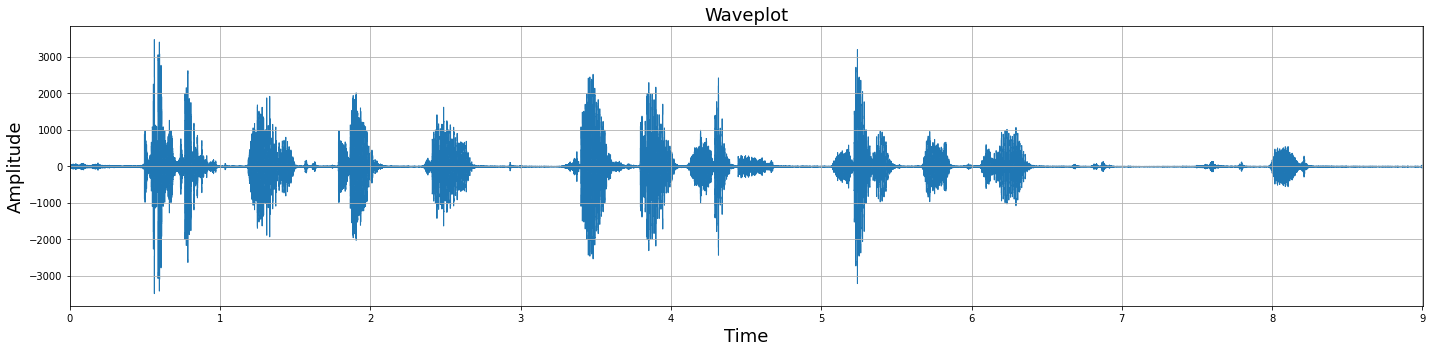

In [7]:
recorded_signal_f = np.frombuffer(recorded_signal, dtype='int16').astype('float32')
plt.figure(figsize=(20, 5))
t_ignore = 1
librosa.display.waveshow(recorded_signal_f[t_ignore*RATE:], sr=RATE)
plt.title('Waveplot', fontdict=dict(size=18))
plt.xlabel('Time', fontdict=dict(size=18))
plt.ylabel('Amplitude', fontdict=dict(size=18))
plt.xlim(0,tf-t_ignore)
plt.savefig('./data/mic_recorder_0.png', bbox_inches='tight', dpi=300)
plt.show()

In [117]:
y = recorded_signal_f[t_ignore*RATE:]
y = y/max(y)
N = len(y)
fs = RATE
T = N/fs
t = np.arange(N)*T/N

In [118]:
Y_fft = fft(y)
f_bl = fftfreq(N, 1/fs)

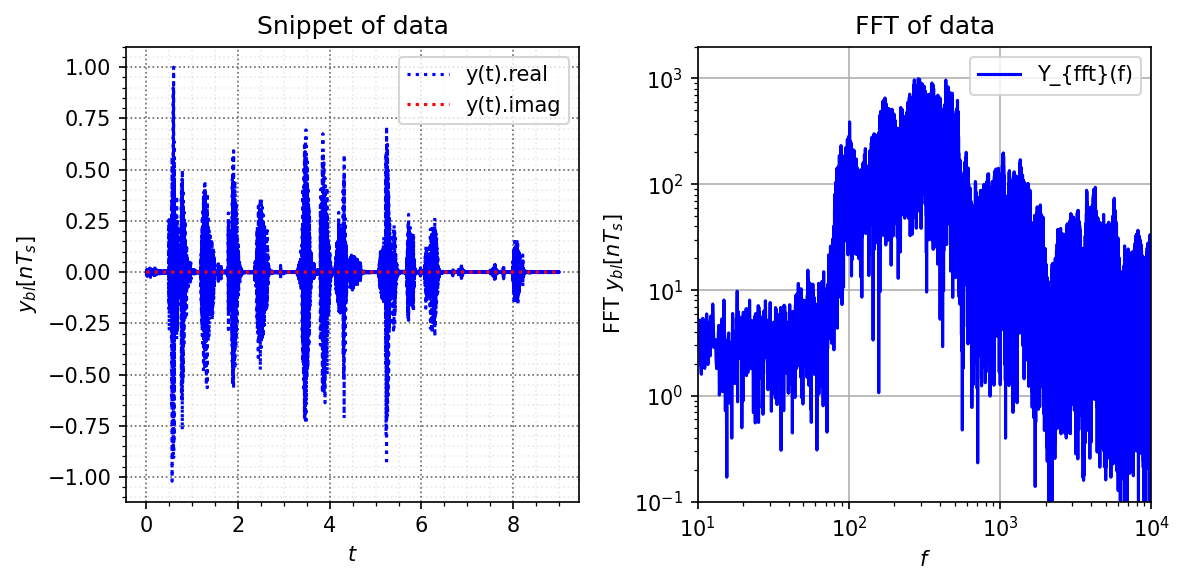

In [119]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4), dpi=150)
fig.tight_layout(pad=2)
ax1.plot(t, y.real, 'b:', t, y.imag, 'r:')
ax1.set_ylabel('$y_{bl}[nT_s]$')
ax1.set_xlabel('$t$')
ax2.set_xlim([0, 19])
ax1.legend(['y(t).real','y(t).imag'])
ax1.set_title('Snippet of data')
nicegrid(ax1)

ax2.loglog(f_bl[0:N//2], np.abs(Y_fft[0:N//2]),'b-')
ax2.set_ylabel('FFT $y_{bl}[nT_s]$')
ax2.set_xlabel('$f$')
ax2.set_xlim([10, 10000])
ax2.set_ylim([.1, 2000])
ax2.legend(['Y_{fft}(f)','Y_{given}(f)'])
ax2.set_title('FFT of data')
plt.show()

In [120]:
# bounds of noise in Y(f)
f_low = 200
f_high = 20000

# conversion from frequency to index count 
delta_freq = fs/N

# find equivalent positions in Y(f) 
n_low = int(f_low/delta_freq)
n_high = int(f_high/delta_freq)
L1 = np.arange(n_low,n_high) # noise indices

# create noise vector
Y_n = np.zeros((N,), dtype=complex)
# create random phase needed for correct ifft process
rng = np.random.default_rng()
phi = rng.uniform(0, 2*np.pi, (len(L1),))

# create Y(f)
if (0): # half-sine shape noise
    mag_temp = np.sin(np.pi*np.arange(0,n_high-n_low)/(n_high-n_low))
else: # rect noise
    mag_temp = 850*np.ones([1,n_high-n_low])
    
Y_n[L1] = mag_temp*np.exp(1j*phi)
# add complex conjugate at upper end to ensure that y[n] real
Y_n[N-L1] = np.conj(Y_n[L1])

# create y[n]
noise = ifft(Y_n)

In [121]:
yn = y + noise.real
Y_fft_n = fft(yn)

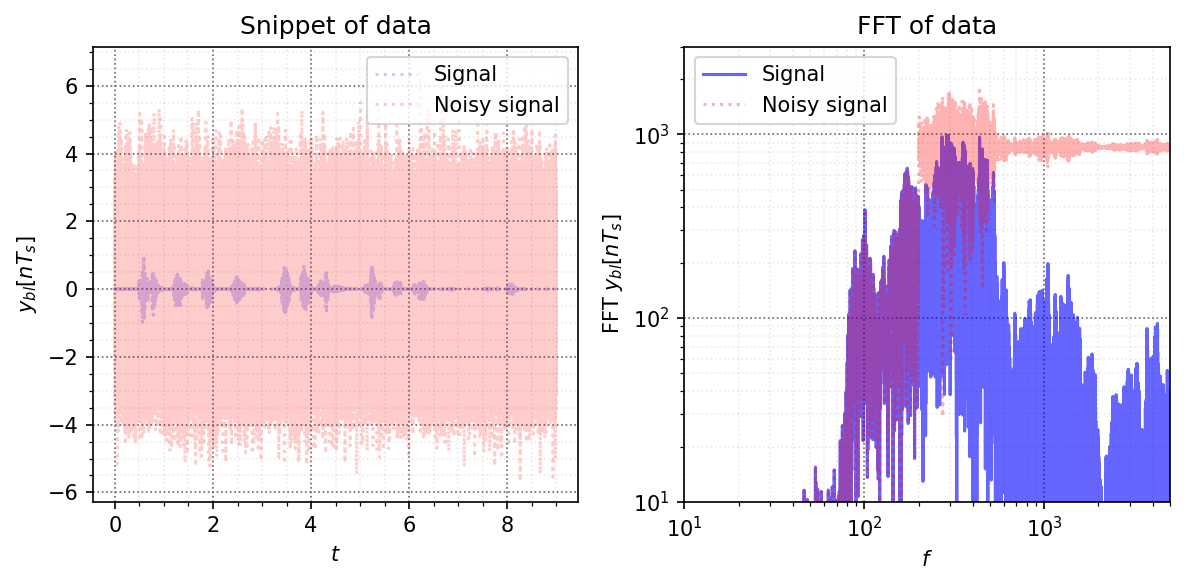

In [122]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4), dpi=150)
fig.tight_layout(pad=2)
ax1.plot(t, y, 'b:', t, yn, 'r:',alpha=0.2)
ax1.set_ylabel('$y_{bl}[nT_s]$')
ax1.set_xlabel('$t$')
ax1.legend(['Signal','Noisy signal'])
ax2.set_xlim([0, 19])
ax1.set_title('Snippet of data')
nicegrid(ax1)

ax2.loglog(f_bl[0:N//2], np.abs(Y_fft[0:N//2]),'b-',alpha=0.6)
ax2.loglog(f_bl[0:N//2], np.abs(Y_fft_n[0:N//2]),'r:',alpha=0.3)
ax2.set_ylabel('FFT $y_{bl}[nT_s]$')
ax2.set_xlabel('$f$')
ax2.set_xlim([10, 5000])
ax2.set_ylim([10, 3000])
ax2.legend(['Signal','Noisy signal'])
ax2.set_title('FFT of data')
nicegrid(ax2)
plt.show()

In [123]:
# Low Pass
b_low, a_low = signal.butter(2, 200, 'low', fs=fs)
f_low, h_low = signal.freqz(b_low, a_low,fs=fs,worN=1000)
yn_lp = signal.lfilter(b_low, a_low, yn)
Yn_lp_fft = fft(yn_lp)

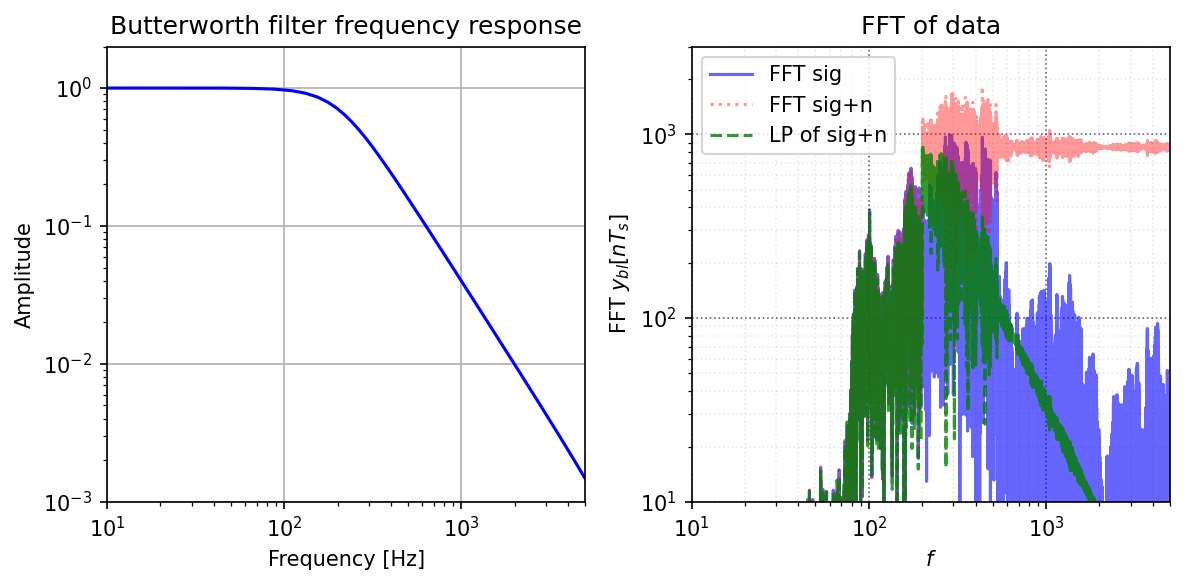

In [124]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4), dpi=150)
fig.tight_layout(pad=2)
eps = 1e-12
ax1.loglog(f_low, abs(h_low+eps),'b-',label='LP')
ax1.set_title('Butterworth filter frequency response')
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('Amplitude')
ax1.set_xlim([10, 5000])
ax1.set_ylim([.001, 2])
nicegrid()

ax2.loglog(f_bl[0:N//2], np.abs(Y_fft[0:N//2]),'b-',alpha=0.6)
ax2.loglog(f_bl[0:N//2], np.abs(Y_fft_n[0:N//2]),'r:',alpha=0.4)
ax2.loglog(f_bl[0:N//2], np.abs(Yn_lp_fft[0:N//2]),'g--',alpha = .8)
ax2.set_ylabel('FFT $y_{bl}[nT_s]$')
ax2.set_xlabel('$f$')
ax2.set_xlim([10, 5000])
ax2.set_ylim([10, 3000])
ax2.legend(['FFT sig','FFT sig+n','LP of sig+n'])
ax2.set_title('FFT of data')
plt.show()

In [125]:
# save the data
y_norm = y/max(abs(y))
write("data/example.wav", RATE, y_norm.astype(np.float32))
yn_norm = yn/max(abs(yn))
write("data/example_noisy.wav", RATE, yn_norm.astype(np.float32))
yn_lp_norm = yn/max(abs(yn_lp))
write("data/example_noisy_lp.wav", RATE, yn_lp_norm.astype(np.float32))

## Modulation

In [126]:
Nc = 2
# Develop 3 carriers to modulate the signal
f_carrier = [6000, 13000, 16000]

II = np.arange(0,N//Nc)
N_t1 = len(II)
t1 = np.zeros([Nc,N_t1])
y_signal = np.zeros([Nc,N_t1])
y_carrier = np.zeros([Nc,N_t1])
Y = np.zeros([Nc,N_t1], dtype = complex)
# Split the signal into 3 pieces, then modulate each one
for ii in np.arange(0,Nc):
    t1[ii,:] = t[ii*(N//Nc)+II]
    y_signal[ii,:] = y[ii*(N//Nc)+II]
    y_carrier[ii,:] = np.cos(2*np.pi*f_carrier[ii]*t1[ii,:])
    Y[ii,:] = fft(y_signal[ii,:])
    
y_modulated = y_signal[0,:]*y_carrier[0,:] 
for ii in np.arange(1,Nc):
    y_modulated += y_signal[ii,:]*y_carrier[ii,:] 

Y_modulated = fft(y_modulated)
f_modulated = fftfreq(N_t1, 1/fs)

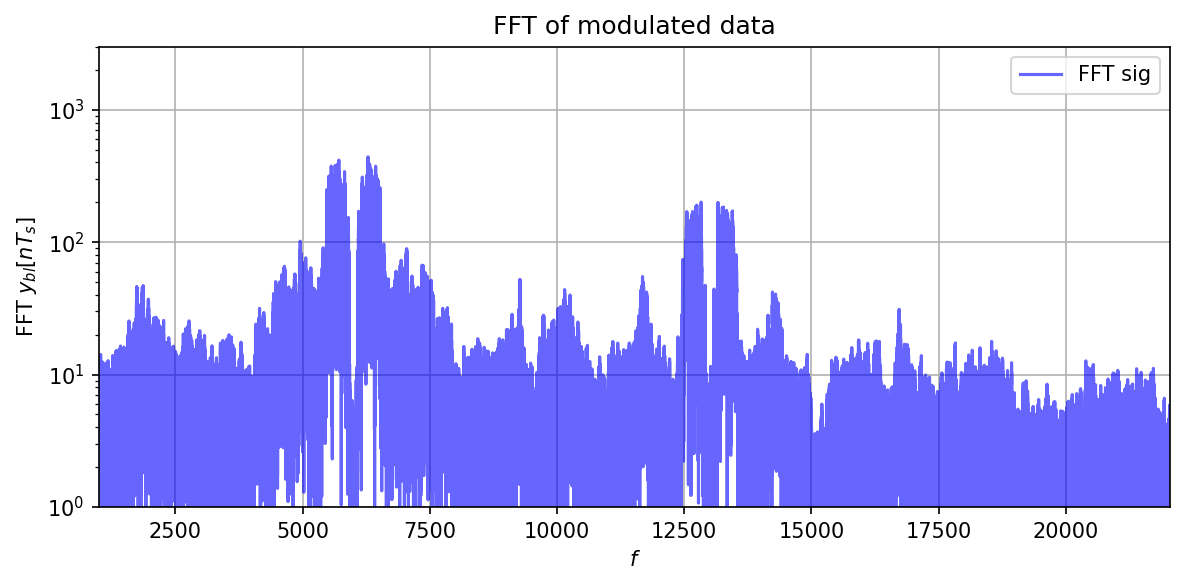

In [127]:
fig, (ax1) = plt.subplots(1,1, figsize=(8,4), dpi=150)
ax1.semilogy(f_modulated[0:N_t1//2], np.abs(Y_modulated[0:N_t1//2]),'b-',alpha=0.6)
ax1.set_ylabel('FFT $y_{bl}[nT_s]$')
ax1.set_xlabel('$f$')
ax1.set_xlim([1000, fs/2])
ax1.set_ylim([1, 3000]) 
ax1.legend(['FFT sig','FFT sig+n','LP of sig+n'])
ax1.set_title('FFT of modulated data')
plt.show()

## Demodulate Signal and low-pass filter

In [128]:
f_voice_lp = 2000
bb_low, aa_low = signal.butter(2, f_voice_lp, 'low', fs=fs)

y_demodulated = np.zeros([Nc,N_t1])
y_demodulated_lp = np.zeros([Nc,N_t1])
Y_demodulated_lp = np.zeros([Nc,N_t1],dtype = complex)
# Split the signal into 3 pieces, then modulate each one
for ii in np.arange(0,Nc):
    y_demodulated[ii,:] = y_modulated*y_carrier[ii,:] 
    y_demodulated_lp[ii,:] = signal.lfilter(bb_low, aa_low, y_demodulated[ii,:])
    Y_demodulated_lp[ii,:] = fft(y_demodulated_lp[ii,:])


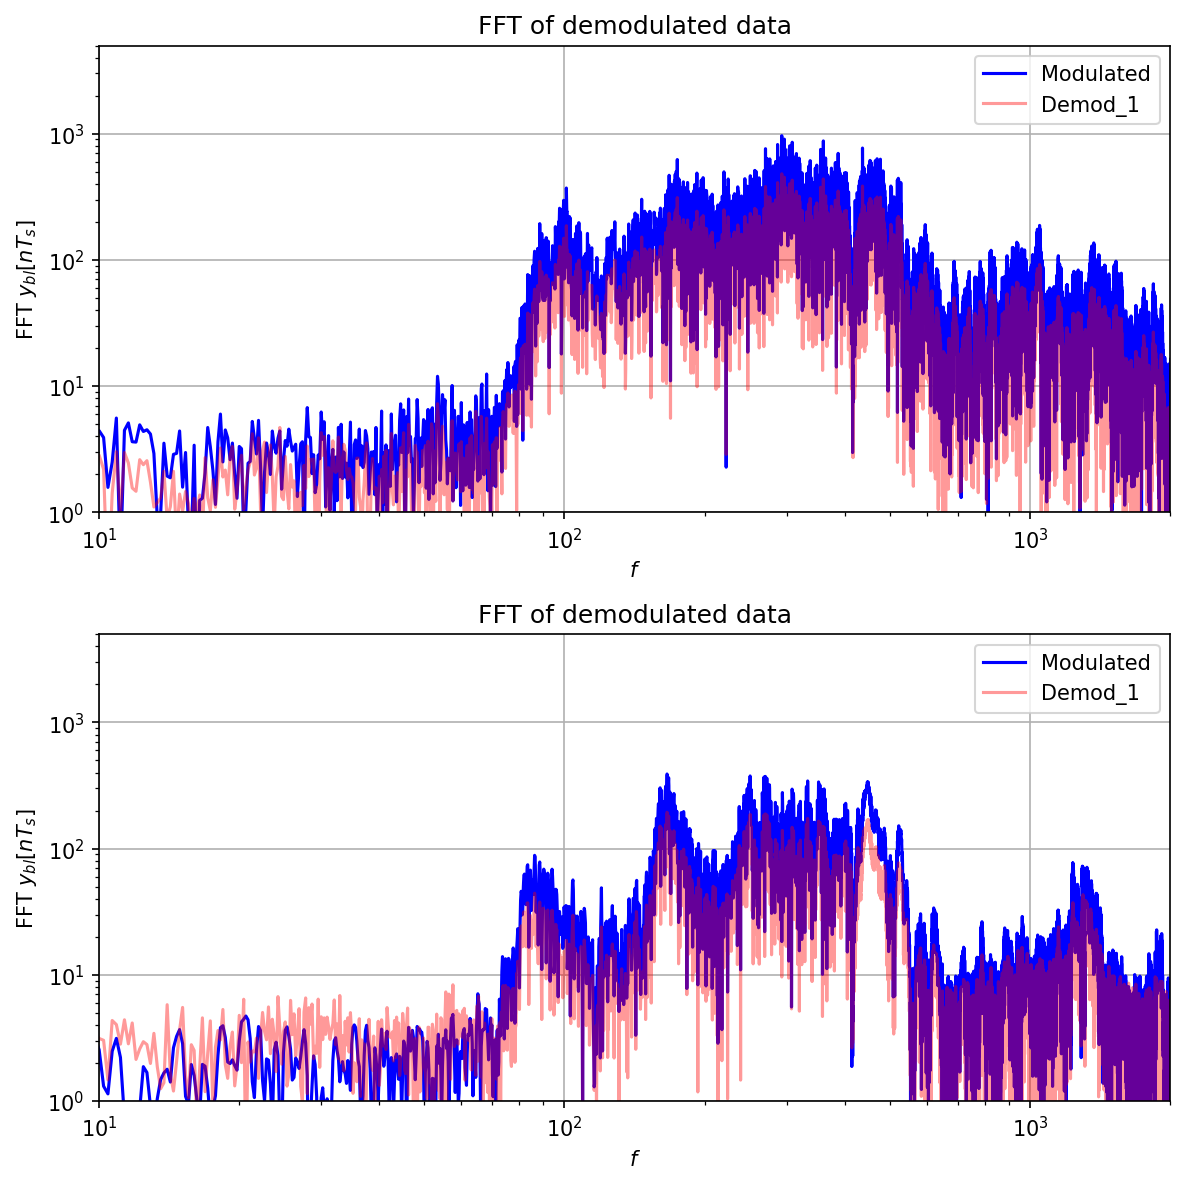

In [137]:
if Nc > 2:
    fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(8,8), dpi=150)
else:
    fig, (ax1,ax2) = plt.subplots(2,1, figsize=(8,8), dpi=150)

def plt_ftn(ax,ii):
    ax.loglog(f_modulated[0:N_t1//2-1], np.abs(Y[ii,0:N_t1//2-1]),'b-',alpha=1)
    ax.loglog(f_modulated[0:N_t1//2], np.abs(Y_demodulated_lp[ii,0:N_t1//2]),'r-',alpha=0.4)
    ax.set_ylabel('FFT $y_{bl}[nT_s]$')
    ax.set_xlabel('$f$')
    ax.set_xlim([10, 2000])
    ax.set_ylim([1, 5000])
    ax.legend(['Modulated','Demod_1'])
    ax.set_title('FFT of demodulated data')

plt_ftn(ax1,0)    
plt_ftn(ax2,1)    
if Nc > 2:
    plt_ftn(ax3,2)    

plt.show()

## Save the modulated and demodulated signals

In [138]:
y_modulated_norm = y_modulated/max(abs(y_modulated))
write("data/example_modulated.wav", RATE, y_modulated_norm.astype(np.float32))

for ii in np.arange(0,Nc):
    y_demodulated_lp_norm = y_demodulated_lp[ii,:] /max(abs(y_demodulated_lp[ii,:]))
    write("data/example_demodulated_"+str(ii+1)+"_lp.wav", RATE, y_demodulated_lp_norm.astype(np.float32))


In [139]:
len(y_modulated_norm)

198366

In [140]:
y_modulated_norm_long = y_modulated_norm
for ii in range(0,10):
    print(f"{ii:.0f} ",  end = '')
    y_modulated_norm_long = np.concatenate((y_modulated_norm_long,y_modulated_norm))

0 1 2 3 4 5 6 7 8 9 

In [133]:
write("data/example_modulated.wav", RATE, y_modulated_norm_long.astype(np.float32))

In [134]:
len(y_modulated_norm_long)

2182026

In [ ]:
A = 'ax'
for ii=np.arrange(0,2)
    